<a href="https://colab.research.google.com/github/JavierC11/Forecast_RandomForest_Python/blob/main/RANDOMFOREST_Prediccion_Forescast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
#Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [89]:
#Cargamos el dataset proporcionado
df = pd.read_csv('/content/DATA.csv')

In [90]:
df.head()

,created_at,city_locality,state_province,length,width,height
0,2023-05-15 08:29:15.681 -0600,CHICAGO,IL,20.0,12.0,14.0
1,2023-09-09 13:33:21.782 -0600,CRANFORD,NJ,22.0,15.8,13.8
2,2023-04-27 05:51:59.692 -0600,MILTON,DE,13.0,10.1,5.9
3,2023-02-08 21:31:03.099 -0600,New York,NY,0.0,0.0,0.0
4,2023-05-25 13:20:36.210 -0600,FREDERICK,MD,13.0,10.1,5.9


1. Análisis Exploratorio de Datos (EDA):

In [91]:
#Hacemos un estudio de datos rapido para asegurarnos que tenamos la forma correcta, que las columnas
#tengan el tipo de datos correcto y entender los cuartiles de los mismos.
print(df.shape)
print('---------------------------------')
print(df.describe())
print('---------------------------------')
print(df.info())

(100000, 6)
---------------------------------
              length          width         height
count  100000.000000  100000.000000  100000.000000
mean       18.263442      12.685721      10.219126
std         5.378263       4.633035       4.129417
min         0.000000       0.000000       0.000000
25%        15.000000      10.100000       7.600000
50%        20.000000      12.000000       8.600000
75%        22.300000      15.800000      13.800000
max        30.000000      30.000000      30.000000
---------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   created_at      100000 non-null  object 
 1   city_locality   100000 non-null  object 
 2   state_province  100000 non-null  object 
 3   length          100000 non-null  float64
 4   width           100000 non-null  float64
 5   height          100000 no

In [92]:
#Cambiamos el tipo de datos de nuestro campo
df['created_at'] = pd.to_datetime(df['created_at'])

<ipython-input-93-15b2513ae37e>:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  time_series = df.groupby(df['created_at'].dt.to_period('M')).size()


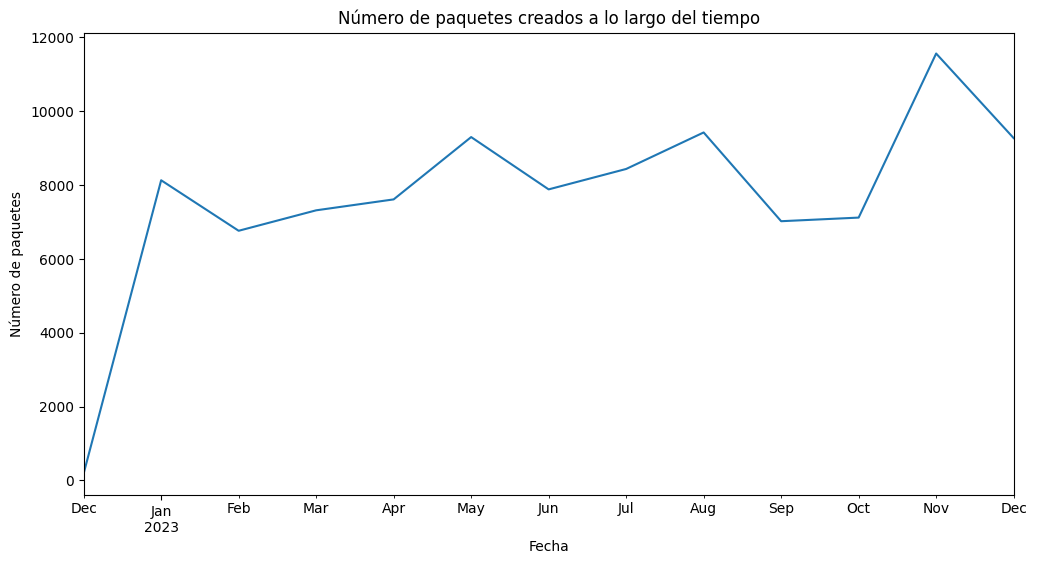

In [93]:
#Creamos una serie temporal del número de paquetes creados
time_series = df.groupby(df['created_at'].dt.to_period('M')).size()

#Visualizamos la serie temporal
plt.figure(figsize=(12, 6))
time_series.plot()
plt.title('Número de paquetes creados a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Número de paquetes')
plt.show()

2. Preprocesamiento de Datos:


In [94]:
#Luego me gustaria saber si tenemo datos nullos y hacer una limepiza de datos,
#Como no tenemos datos nullos pues no necesitamos limpieza de datos,
#En caso de ser necesario podemos usar eliminacion o imputacion de datos dependieto del estado del
#Dataset u otras tecnicas como uso de modelos para predecir los datos nullos que son un poco mas avanzadas
df.isnull().sum()

created_at        0
city_locality     0
state_province    0
length            0
width             0
height            0
dtype: int64

In [95]:
#pd.set_option('display.max_colwidth', None)
# pd.reset_option('display.max_colwidth')

In [96]:
#Contamos cuantas localidades existen
df['city_locality'].nunique()

2762

In [97]:
#Contamos cuantas provincias existen existen
df['state_province'].nunique()

12

In [98]:
#Contamos cuantas provincias existen existen
df['state_province'].value_counts()

state_province
NY    30572
IL    26324
NJ    18417
MD     7239
VA     6403
PA     4378
DC     3545
CT     2182
DE      918
MN       19
FL        2
MA        1
Name: count, dtype: int64

In [99]:
#Como podemos ver tenermos menos provincias por lo que es lo que utilizaremos
#para el modelo, de lo contrario estariamos tomando demaciado procesamiento.
#Si en caso se necesita tomar en cuenta la ciudad obligatoriamente podriamso usar
#tencias para grandes cantidades de categorias como Frequency Encoding pero debemos
#estudiar si vale la pena tomarlas en cuenta.
df = df.drop('city_locality', axis=1)

In [100]:
#Borramos el campo
df = df.drop('state_province', axis=1)

In [101]:
# #Sin en caso queremos usar el campo de state_province, debemos hacer un label encoder
# #ya que todo modelo funciona mejor sin datos categoricos.

# LabelEncoder
# label_encoder = LabelEncoder()

# Ajustar y transformar los datos
# df['state_province'] = label_encoder.fit_transform(df['state_province'])

# Mostrar las primeras filas del DataFrame resultante
# df.head()

In [102]:
#Creamos las varibles de meses y dias de las semanas
df['Month'] = df['created_at'].dt.month
df['Day_Week'] = df['created_at'].dt.dayofweek

#Hacemos una visualizacione rapida de como quedan nuestros nuevos campos
df.head()

,created_at,length,width,height,Month,Day_Week
0,2023-05-15 08:29:15.681000-06:00,20.0,12.0,14.0,5,0
1,2023-09-09 13:33:21.782000-06:00,22.0,15.8,13.8,9,5
2,2023-04-27 05:51:59.692000-06:00,13.0,10.1,5.9,4,3
3,2023-02-08 21:31:03.099000-06:00,0.0,0.0,0.0,2,2
4,2023-05-25 13:20:36.210000-06:00,13.0,10.1,5.9,5,3


3.Contruccion del modelo

In [103]:
#Vemos la correlacion entre las variables
df.corr()

,created_at,length,width,height,Month,Day_Week
created_at,1.000000,0.157246,0.126598,0.095565,0.986413,0.040920
length,0.157246,1.000000,0.866451,0.445546,0.160279,-0.019177
width,0.126598,0.866451,1.000000,0.280478,0.127920,-0.019558
height,0.095565,0.445546,0.280478,1.000000,0.097890,-0.016425
Month,0.986413,0.160279,0.127920,0.097890,1.000000,0.051399
Day_Week,0.040920,-0.019177,-0.019558,-0.016425,0.051399,1.000000


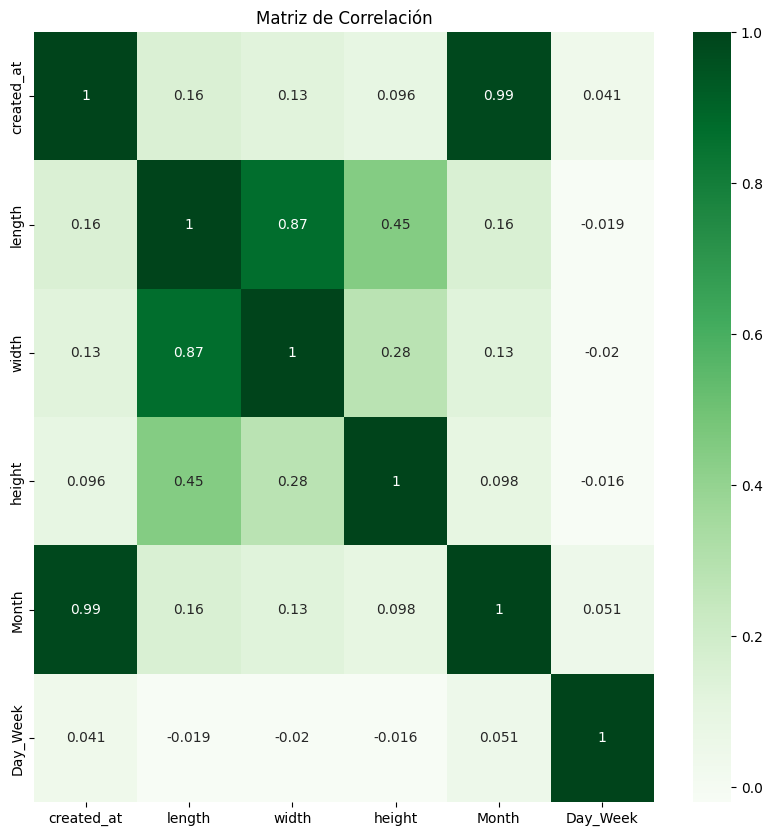

In [104]:
#Pero podemos verlo mucho mas comodo si creamos una vizualizacion con un heatmap
#Ha esto se le llama matriz de correlacion, Como podemos ver campos como el de
#State province tiene una correalcion negativa, no significa nada malo solamente que es
#inversamente correlacionada pero al tener tan poca correlacion lo mejor es que no la tomemos en cuenta
#para de esta manera optimizar nuestro modelo.
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, cmap='Greens')
plt.title('Matriz de Correlación')
plt.show()

In [105]:
# Convertir las fechas a números (días desde la fecha mínima)
df['days_since'] = (df['created_at'] - df['created_at'].min()).dt.days

In [106]:
#Ahora como siempre partiremos los datos de test and train para finalmente crear nuestor
#modelo de random forest
X = df.drop(['days_since','created_at'], axis=1)
y = df['days_since']



Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

In [107]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   length    100000 non-null  float64
 1   width     100000 non-null  float64
 2   height    100000 non-null  float64
 3   Month     100000 non-null  int32  
 4   Day_Week  100000 non-null  int32  
dtypes: float64(3), int32(2)
memory usage: 3.1 MB


In [108]:
#Creamos el modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(Xtrain,ytrain)

RandomForestRegressor(random_state=42)

4. Evaluacion del modelo

In [109]:
# Evaluación del modelo
y_pred = model.predict(Xtest)
mae = mean_absolute_error(ytest, y_pred)
rmse = mean_squared_error(ytest, y_pred, squared=False)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

MAE: 8.264035303964105
RMSE: 16.68960753687015


In [110]:
X.head()

,length,width,height,Month,Day_Week
0,20.0,12.0,14.0,5,0
1,22.0,15.8,13.8,9,5
2,13.0,10.1,5.9,4,3
3,0.0,0.0,0.0,2,2
4,13.0,10.1,5.9,5,3


In [111]:
#Creamos un dataframe con fechas futuras para el forecast
future_dates = pd.date_range(start='2024-01-01', periods=165, freq='D')
future_data = pd.DataFrame({
#    'state_province': np.random.randint(0, 11, size=165),      En caso de ser tomado en cuanta en el entranamiento podemos descomentar este campo
    'length': np.random.randint(10, 100, size=165),
    'width': np.random.randint(10, 100, size=165),
    'height': np.random.randint(10, 100, size=165),
    'Month': future_dates.month,
    'Day_Week': future_dates.dayofweek
})

In [112]:
#Realizamos las predicciones para usar en el forecast
future_predictions = model.predict(future_data)

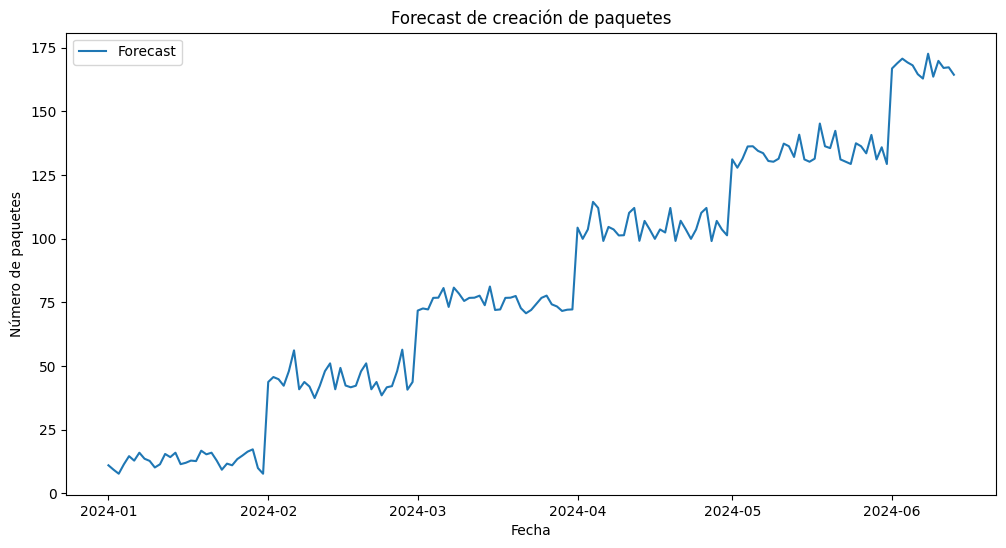

In [113]:
#Creamos una grafica del forecast
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_predictions, label='Forecast')
plt.title('Forecast de creación de paquetes')
plt.xlabel('Fecha')
plt.ylabel('Número de paquetes')
plt.legend()
plt.show()

Conclusiones:

*   Se realizo un analisis de datos con el dataset recibido.
*   Si es posible crear un modelo con estos datos.
*   El model presenta unas metricas de error bajas por lo que sabemos que el modelo es optimo.
*   En caso de ser necesesario podemos iterar el modelo por ejemplo quitando campos las cuales no estan aportanto a los pesos del entrenamiento y de esta manera obtener un modelo mas eficiente.